## Visualising Data
#### Source : kaggle : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce:


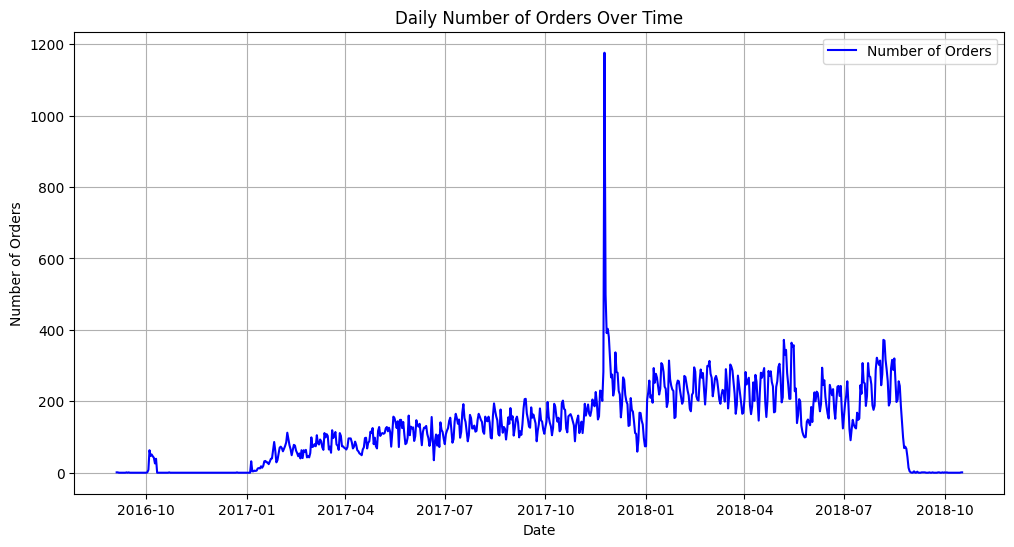

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('olist_orders_with_row_index.csv')

# Convert order_purchase_timestamp to datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Resample data to daily frequency and count orders per day
df_daily = df.resample('D', on='order_purchase_timestamp').size()

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily.values, label='Number of Orders', color='blue')
plt.title('Daily Number of Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)

## Uploading Data to Elastic

In [4]:
from elasticsearch import Elasticsearch

# Connect to Elasticsearch with scheme
es = Elasticsearch(
    [{'host': 'localhost', 'port': 9200, 'scheme': 'http'}]
)

In [5]:
# Define index name
index_name = 'row_number'

# Load the CSV file into a DataFrame
csv_file_path = 'olist_orders_with_row_index.csv'
df = pd.read_csv(csv_file_path)

# Define the mapping for the index
mapping = {
    "mappings": {
        "properties": {
            "row_number": {"type": "integer"},
            "order_id": {"type": "keyword"},
            "customer_id": {"type": "keyword"},
            "order_status": {"type": "keyword"},
            "order_purchase_timestamp": {"type": "date", "format": "strict_date_optional_time||epoch_millis"}
            # Add other fields as needed
        }
    }
}

In [6]:
# Create the index with the mapping if it doesn't exist
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body=mapping)

In [ ]:
# Prepare data for bulk upload
def generate_actions(dataframe):
    for _, row in dataframe.iterrows():
        yield {
            "_index": index_name,
            "_id": row['row_number'],  # Use row_number as document ID
            "_source": row.dropna().to_dict()
        }

# Bulk upload to Elasticsearch
helpers.bulk(es, generate_actions(df))

print("Data uploaded successfully.")

## Retrieving Data from Elastic

In [7]:
# Define index name
index_name = 'row_number'

# Define start and end dates
start_date = "2016-01-06T00:00:00"
end_date = "2018-10-07T23:59:59"

# Define the query
query = {
    "query": {
        "range": {
            "order_purchase_timestamp": {
                "gte": start_date,
                "lte": end_date
            }
        }
    }
}

# Initialize scroll
scroll_size = 1000  # Number of documents to retrieve per batch
scroll_time = '2m'  # Time to keep scroll context alive

# Start scrolling
response = es.search(index=index_name, body=query, scroll=scroll_time, size=scroll_size)
scroll_id = response['_scroll_id']
hits = response['hits']['hits']

# Collect all hits
all_hits = []
while len(hits) > 0:
    all_hits.extend(hits)
    response = es.scroll(scroll_id=scroll_id, scroll=scroll_time)
    scroll_id = response['_scroll_id']
    hits = response['hits']['hits']

# Convert hits to a DataFrame
data = [hit['_source'] for hit in all_hits]
df = pd.DataFrame(data)

# Display the DataFrame
df.info()

C:\Users\vishwas-247commerce\AppData\Local\Temp\ipykernel_37868\1474153617.py:25: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(index=index_name, body=query, scroll=scroll_time, size=scroll_size)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99922 entries, 0 to 99921
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   row_number                     99922 non-null  int64 
 1   order_id                       99922 non-null  object
 2   customer_id                    99922 non-null  object
 3   order_status                   99922 non-null  object
 4   order_purchase_timestamp       99922 non-null  object
 5   order_approved_at              99764 non-null  object
 6   order_delivered_carrier_date   98141 non-null  object
 7   order_delivered_customer_date  96959 non-null  object
 8   order_estimated_delivery_date  99922 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.9+ MB


## Using Autogen, Elastic, ADTK for anomaly detection

In [17]:
import pandas as pd
from adtk.data import validate_series
from adtk.detector import ThresholdAD
import os
from autogen import ConversableAgent
from autogen import register_function
from datetime import datetime

In [18]:
import os
os.environ["OPENAI_API_KEY"] = "Your key"

### Defining a custom tool with Elastic and ADTK

In [19]:
def calculator(date: str) -> str:
    
    ##Date processing
    date_object = datetime.strptime(date, "%B %d %Y")
    formatted_date = date_object.strftime("%Y-%m-%dT%H:%M:%S")
    ##Date processing

    
    ##Query for Elastic
    query = {
        "query": {
            "range": {
                "order_purchase_timestamp": {
                    "gte": formatted_date,
                    "lte": "2018-07-07T23:59:59"
            }
        }
    }
}
    ##Query for Elastic

    
    #Retrieving Data
    response = es.search(index=index_name, body=query, scroll='2m', size=1000)
    scroll_id = response['_scroll_id']
    hits = response['hits']['hits']
    all_hits = []
    while len(hits) > 0:
        all_hits.extend(hits)
        response = es.scroll(scroll_id=scroll_id, scroll=scroll_time)
        scroll_id = response['_scroll_id']
        hits = response['hits']['hits']
    data = [hit['_source'] for hit in all_hits]
    df = pd.DataFrame(data)
    #Retrieving Data



    ## Preprocessing 
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    df.set_index('order_id', inplace=True)
    df_daily = df.resample('D', on='order_purchase_timestamp').size()
    s = validate_series(df_daily)
    ## Preprocessing 

    
    ## Detecting anomalies
    threshold_ad = ThresholdAD(high=350, low=10)
    anomalies = threshold_ad.detect(s)
    anomaly_dates = anomalies[anomalies].index.date
    ## Detecting anomalies

    
    ##Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(df_daily.index, df_daily.values, label='Daily Order Count', color='blue')
    plt.scatter( df_daily.index[df_daily.index.isin(anomaly_dates)],df_daily[df_daily.index.isin(anomaly_dates)],color='red',label='Anomaly',zorder=5)
    plt.title('Daily Order Count with Anomalies Highlighted')
    plt.xlabel('Date')
    plt.ylabel('Order Count')
    plt.legend()
    plt.grid(True)
    plt.savefig('daily_order_count_with_anomalies.png')
    #plotting
    return(str(anomaly_dates))

### Defining an agent

In [20]:
# Let's first define the assistant agent that suggests tool calls.
assistant = ConversableAgent(
    name="Assistant",
    system_message="You are a helpful AI assistant. "
    "You can help with analysing anomalies (Order spikes) in the given date. Get the response from calling tool and generate a report in 100 words to let the user know when the order spikes have been occured. Use bullet points. its a must"
    "Return 'TERMINATE' when the task is done.",
    llm_config={"config_list": [{"model": "gpt-4", "api_key": os.environ["OPENAI_API_KEY"]}]},
)

[autogen.oai.client: 10-02 05:55:19] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.


### Defining User proxy agent

In [21]:
# The user proxy agent is used for interacting with the assistant agent
# and executes tool calls.
user_proxy = ConversableAgent(
    name="User",
    llm_config=False,
    is_termination_msg=lambda msg: msg.get("content") is not None and "TERMINATE" in msg["content"],
    human_input_mode="NEVER",
)

### Registering Tool

In [22]:
from autogen import register_function

# Register the calculator function to the two agents.
register_function(
    calculator,
    caller=assistant,  # The assistant agent can suggest calls to the calculator.
    executor=user_proxy,  # The user proxy agent can execute the calculator calls.
    name="anomalydetector",  # By default, the function name is used as the tool name.
    description="detects order spikes from the input user gives",  # A description of the tool.
)


[autogen.oai.client: 10-02 05:55:23] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.


### Executing Agent

User (to Assistant):

Detect anomaly from January 5 2018

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

***** Suggested tool call (call_XtZ6IGmxbGuEvnF8gaofdLYp): anomalydetector *****
Arguments: 
{
  "date": "January 5 2018"
}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION anomalydetector...


C:\Users\vishwas-247commerce\AppData\Local\Temp\ipykernel_37868\1017528851.py:24: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(index=index_name, body=query, scroll='2m', size=1000)
C:\Users\vishwas-247commerce\AppData\Local\Temp\ipykernel_37868\1017528851.py:57: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  plt.scatter( df_daily.index[df_daily.index.isin(anomaly_dates)],df_daily[df_daily.index.isin(anomaly_dates)],color='red',label='Anomaly',zorder=5)


User (to Assistant):

User (to Assistant):

***** Response from calling tool (call_XtZ6IGmxbGuEvnF8gaofdLYp) *****
[datetime.date(2018, 5, 7) datetime.date(2018, 5, 14)
 datetime.date(2018, 5, 15) datetime.date(2018, 5, 16)]
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

Based on the analysis, there were noticeable order spikes on the following dates:
- May 7, 2018
- May 14, 2018
- May 15, 2018
- May 16, 2018

These sudden increases in orders could be due to various factors such as promotions, special events, or changes in market demand. Further investigation is needed to determine the exact causes for these anomalies. You are also encouraged to monitor future trends to detect spikes promptly and manage them effectively for business stability.

--------------------------------------------------------------------------------
User (

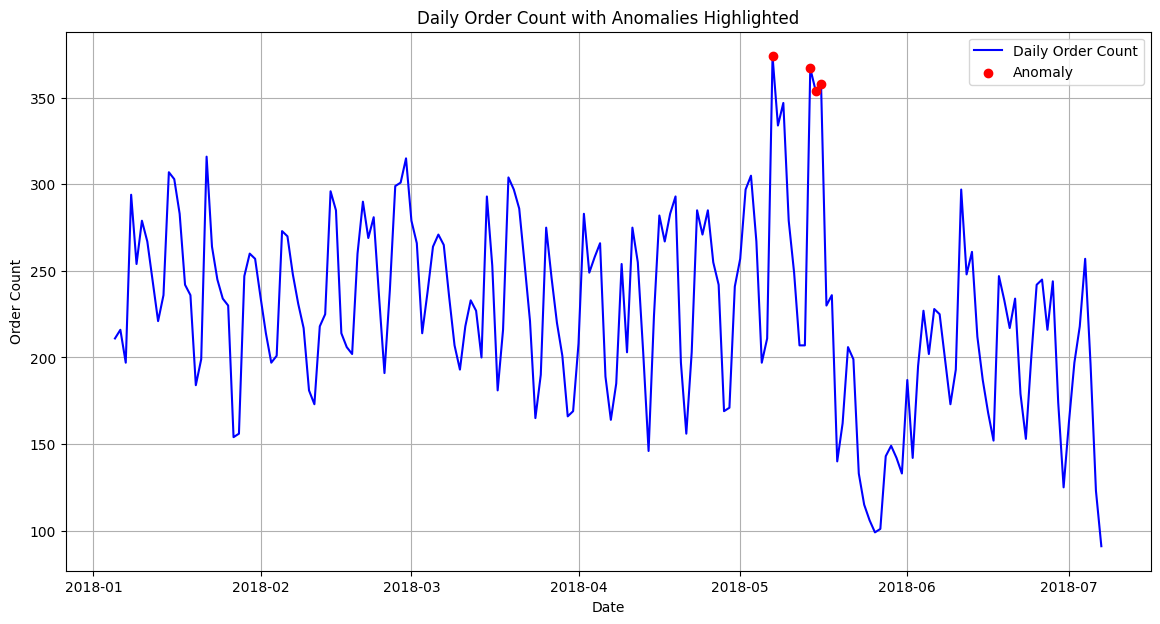

In [24]:
chat_result = user_proxy.initiate_chat(assistant, message="Detect anomaly from January 5 2018")